# **ME 193, Spring 2021**
## Final Project Notebook 


**Notes**:

1. 

In [3]:
import os
import numpy as np
import pandas as pd
import requests
from IPython.display import JSON

import sklearn.tree as tree
import sklearn.metrics as mt
import sklearn.ensemble as ens
import matplotlib.pyplot as plt
import sklearn.model_selection

import seaborn as sns
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

## Import data DO NOT RUN
Scrape vivino website by analyzing Network tab on the all search and pulling API request info. id = 1 is red wines and id = 2 is whites. Parems for search included
Red network url: https://www.vivino.com/api/explore/explore?country_code=US&currency_code=USD&grape_filter=varietal&min_rating=1&order_by=ratings_average&order=desc&page=1&price_range_max=500&price_range_min=0&wine_type_ids[]=1

In [47]:
url = "https://www.vivino.com/api/explore/explore"
headers= {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}
#page_num = 1
matches = []

# loops through pages; ~40,000 wines, 25 per page -> ~1600 pages; but sample less
for i, page_num in enumerate(range(1000, 1650)):
    r = requests.get(url,
        params = {
            "country_code": "US",
            "currency_code":"USD",
            "grape_filter":"varietal",
            "min_rating":"1",
            "order_by":"ratings_average",
            "order":"desc",
            "page": page_num,
            "price_range_max":"450",
            "price_range_min":"0",
            "wine_type_ids[]":"1"
        }, headers=headers)
    print(page_num, end='\r')
    reds = r.json()
    matches.extend(reds["explore_vintage"]["matches"])
print('data aquired')

data aquired


In [48]:
results = [
    (
        t["vintage"]["wine"]["winery"]["name"], 
        #f'{t["vintage"]["wine"]["name"]} {t["vintage"]["year"]}',
        t["vintage"]["wine"]["name"],
        t["price"]["amount"],
        t["vintage"]["year"],
        t["vintage"]["wine"]["style"]["varietal_name"] if t["vintage"]["wine"]["style"] != None else float("NaN"),
        t["vintage"]["wine"]["region"]["name"],
        t["vintage"]["wine"]["region"]["country"]["name"],
        t["vintage"]["statistics"]["ratings_average"],
        t["vintage"]["wine"]["taste"]["structure"]["acidity"] if t["vintage"]["wine"]["taste"]["structure"] != None else float("NaN"),
        t["vintage"]["wine"]["taste"]["structure"]["sweetness"] if t["vintage"]["wine"]["taste"]["structure"] != None else float("NaN"),
        t["vintage"]["wine"]["taste"]["structure"]["tannin"] if t["vintage"]["wine"]["taste"]["structure"] != None else float("NaN"),
        # flavors
        [j["group"] for j in t["vintage"]["wine"]["taste"]["flavor"]] if t["vintage"]["wine"]["taste"]["flavor"] != None else float("NaN")
    ) for t in matches
]

df_reds2 = pd.DataFrame(results,columns=['Winery','Wine','Price','Year','Grape','Region','Country','Rating','Acidity','Sweetness','Tannin','Flavor'])
#df_reds = pd.DataFrame(results,columns=['Winery','Wine','Price','Year','Region','Country','Rating','Acidity','Sweetness','Tannin','Flavor'])
print(page_num)
print(len(df_reds2))
df_reds2.head()
#df_reds.to_pickle("./reds.pkl")  # saves the database

1649
16250


,Winery,Wine,Price,Year,Grape,Region,Country,Rating,Acidity,Sweetness,Tannin,Flavor
0,Foppiano Vineyards,Petite Sirah,25.00,2016,Petite Sirah,Russian River Valley,United States,4.3,3.462071,1.616064,4.332947,"[black_fruit, oak, spices, non_oak, red_fruit,..."
1,Château Rauzan-Ségla,Margaux (Grand Cru Classé),199.99,2001,Margaux,Margaux,France,4.3,4.170783,1.595496,3.878739,"[oak, earth, black_fruit, non_oak, spices, red..."
2,Zuccardi,Aluvional Altamira,99.99,2014,Malbec,Paraje Altamira,Argentina,4.3,2.868278,2.057373,2.738378,"[black_fruit, oak, earth, red_fruit, spices, n..."
3,Inglenook,Cabernet Sauvignon,58.99,2015,Cabernet Sauvignon,Rutherford,United States,4.3,3.393818,1.535347,3.468171,"[oak, black_fruit, earth, non_oak, red_fruit, ..."
4,De Toren,Z,49.99,2015,Bordeaux Blend,Stellenbosch,South Africa,4.3,3.701327,1.628823,3.371958,"[oak, black_fruit, non_oak, earth, spices, red..."


In [52]:
print(len(df_reds2))
df_reds = df_reds.append(df_reds2, ignore_index=True)
print((df_reds.iloc[1000:1100]))
df_reds.head()
df_reds.to_pickle("./reds.pkl")  # saves the database

16250
                         Winery                                         Wine  \
1000                   De Toren                                     Fusion V   
1001                Mollydooker                         Blue Eyed Boy Shiraz   
1002  Château Ducru-Beaucaillou              Saint-Julien (Grand Cru Classé)   
1003       Château Pape Clément  Pessac-Léognan (Grand Cru Classé de Graves)   
1004                    EnRoute                      Les Pommiers Pinot Noir   
...                         ...                                          ...   
1095             Château Talbot              Saint-Julien (Grand Cru Classé)   
1096                   Duckhorn                  Three Palms Vineyard Merlot   
1097                     Shafer                                   Relentless   
1098                  Mayacamas                           Cabernet Sauvignon   
1099                  Valdicava                       Brunello di Montalcino   

       Price  Year               

,Winery,Wine,Price,Year,Grape,Region,Country,Rating,Acidity,Sweetness,Tannin,Flavor
0,Château Lagrézette,Le Pigeonnier Malbec,186.99,2013,Malbec,Cahors,France,4.8,3.033677,1.683774,3.381870,"[oak, earth, black_fruit, non_oak, spices, mic..."
1,Viña Cobos,Cobos Chañares Estate Malbec,349.99,2016,Malbec,Tunuyán,Argentina,4.8,2.791039,2.112970,2.788464,"[oak, black_fruit, spices, non_oak, floral, ea..."
2,Antinori,Tenuta Tignanello 'Solaia',349.99,2017,Red,Toscana,Italy,4.8,3.077701,1.899224,2.966772,"[oak, earth, black_fruit, non_oak, spices, red..."
3,Frank Family,Patriarch,219.99,2015,Cabernet Sauvignon,Rutherford,United States,4.8,3.327367,1.359278,3.235493,"[oak, earth, non_oak, black_fruit, spices, red..."
4,Realm,Farella Vineyard,239.95,2016,Cabernet Sauvignon,Coombsville,United States,4.8,3.247900,1.583510,3.424210,"[oak, earth, non_oak, black_fruit, spices, red..."


In [53]:
print(len(df_reds))
df_reds.to_pickle("./reds.pkl")  # saves the database

57475


## Load created database with line below START HERE

In [55]:
df_reds = pd.read_pickle("./reds.pkl")
print(len(df_reds))
df_reds.head()

57475


,Winery,Wine,Price,Year,Grape,Region,Country,Rating,Acidity,Sweetness,Tannin,Flavor
0,Château Lagrézette,Le Pigeonnier Malbec,186.99,2013,Malbec,Cahors,France,4.8,3.033677,1.683774,3.381870,"[oak, earth, black_fruit, non_oak, spices, mic..."
1,Viña Cobos,Cobos Chañares Estate Malbec,349.99,2016,Malbec,Tunuyán,Argentina,4.8,2.791039,2.112970,2.788464,"[oak, black_fruit, spices, non_oak, floral, ea..."
2,Antinori,Tenuta Tignanello 'Solaia',349.99,2017,Red,Toscana,Italy,4.8,3.077701,1.899224,2.966772,"[oak, earth, black_fruit, non_oak, spices, red..."
3,Frank Family,Patriarch,219.99,2015,Cabernet Sauvignon,Rutherford,United States,4.8,3.327367,1.359278,3.235493,"[oak, earth, non_oak, black_fruit, spices, red..."
4,Realm,Farella Vineyard,239.95,2016,Cabernet Sauvignon,Coombsville,United States,4.8,3.247900,1.583510,3.424210,"[oak, earth, non_oak, black_fruit, spices, red..."
...,...,...,...,...,...,...,...,...,...,...,...,...
57460,Marqués de Riscal,Rioja Gran Reserva,44.98,2012,Rioja Red,Rioja,Spain,4.3,3.746856,1.690894,3.649824,"[oak, earth, non_oak, black_fruit, spices, red..."
57461,Emidio Pepe,Montepulciano d'Abruzzo,200.99,2010,Montepulciano d'Abruzzo,Montepulciano d'Abruzzo,Italy,4.3,3.883632,1.676100,2.984882,"[earth, oak, red_fruit, black_fruit, non_oak, ..."
57462,Ridge Vineyards,Geyserville,39.99,2018,Red Blend,Alexander Valley,United States,4.3,3.879983,1.825871,3.575902,"[oak, black_fruit, red_fruit, non_oak, spices,..."
57463,ARPEPE,Sassella Rocce Rosse Riserva,124.99,2007,Nebbiolo,Valtellina Superiore,Italy,4.3,4.645599,1.483996,4.288074,"[earth, oak, red_fruit, non_oak, spices, black..."


## Data Exploration

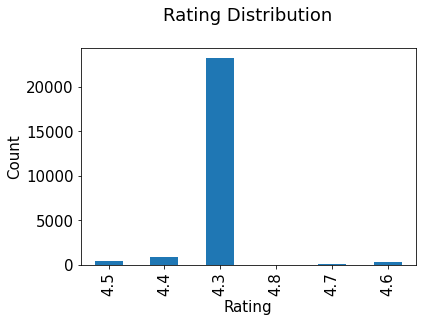

In [11]:
ratings = df_reds[['Rating', 'Grape', 'Country']]

plt.rc("font", size=15)
ratings.Rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count');

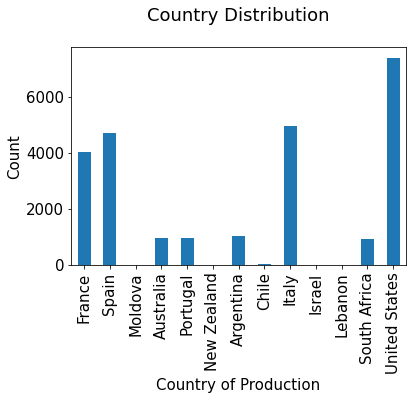

In [12]:
plt.rc("font", size=15)
ratings.Country.value_counts(sort=False).plot(kind='bar')
plt.title('Country Distribution\n')
plt.xlabel('Country of Production')
plt.ylabel('Count');

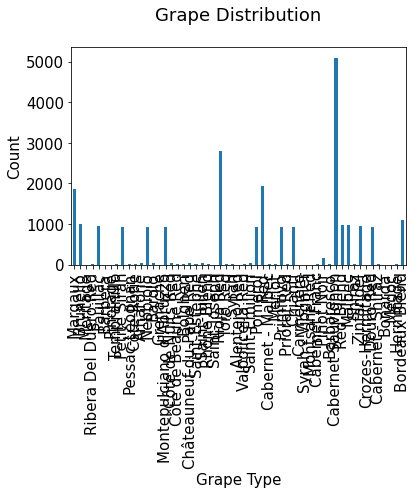

In [13]:
plt.rc("font", size=15)
ratings.Grape.value_counts(sort=False).plot(kind='bar')
plt.title('Grape Distribution\n')
plt.xlabel('Grape Type')
plt.ylabel('Count');

In [14]:
# Define Function to calculate Within Cluster Variance
def withinClusVar(X,centers,labels,labelset):
    variance = []
    for i in labelset:
        variance.append(np.linalg.norm(X[labels==i]-centers[i])**2/len(X[labels==i]))
    return sum(variance)

Text(0, 0.5, 'WCV')

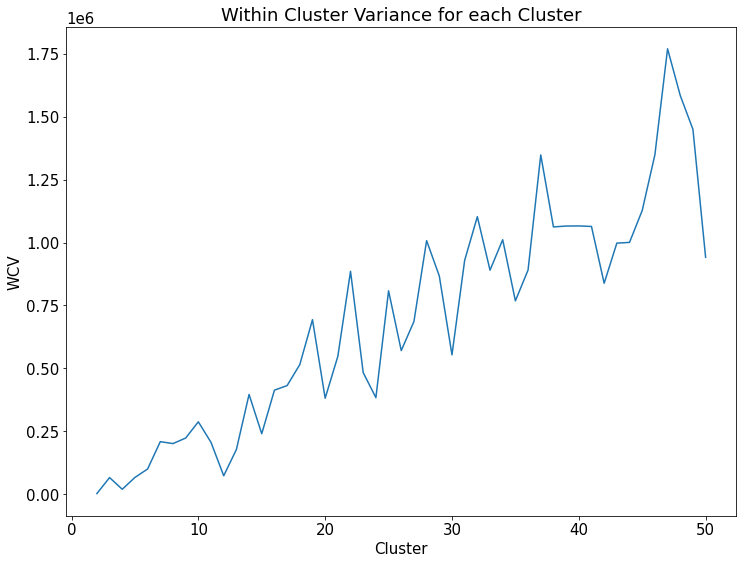

In [43]:
X_test_wine = df_reds.drop(['Winery', 'Wine', 'Grape', 'Region', 'Country', 'Flavor'], axis=1)
X_test_wine["Year"] = pd.to_numeric(X_test_wine["Year"], errors='coerce')
X_test_wine = X_test_wine.dropna()
n_clusters = np.linspace(2,50,49, dtype='int')
withinClusterVar = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init = 10, max_iter=200).fit(X_test_wine)
    centers = kmeans.cluster_centers_
    labels = kmeans.fit_predict(X_test_wine)
    labelset = np.unique(labels)
    
    withinClusterVar.append(withinClusVar(X_test_wine, centers, labels, labelset))

plt.figure(figsize = (12,9)) 
plt.plot(n_clusters, withinClusterVar)
plt.title('Within Cluster Variance for each Cluster')
plt.xlabel('Cluster')
plt.ylabel('WCV')

In [44]:
minWCV = min(withinClusterVar)
indexWCV = withinClusterVar.index(minWCV)
minCluster = n_clusters[indexWCV]
print("The K Value that minimizes the Within Cluster Variance is: K =",minCluster)


The K Value that minimizes the Within Cluster Variance is: K = 2


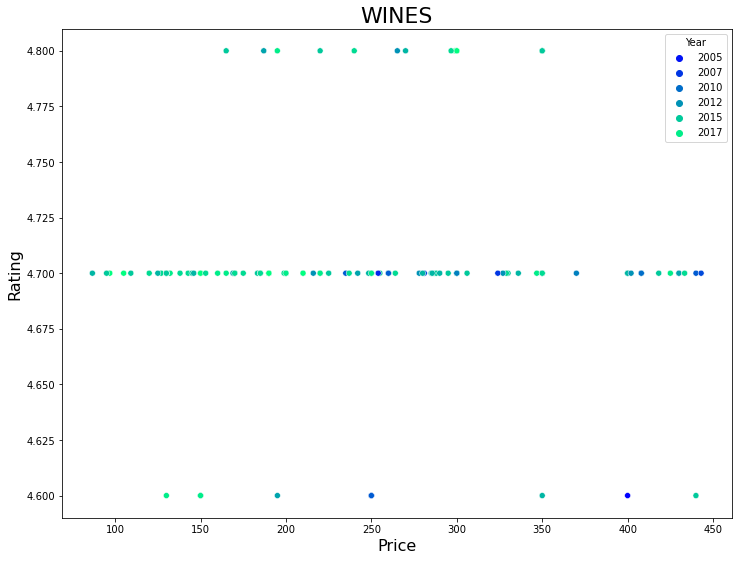

In [35]:
kmeans = KMeans(n_clusters = 2, n_init = 10, max_iter = 300).fit(X_test_wine)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

plt.figure(figsize = (12,9)) 
sns.scatterplot(data=df_reds, x="Price", y="Rating", hue="Year", marker = 'o', legend = 'auto', palette = 'winter')
plt.xlabel('Price', fontsize = '16')
plt.ylabel('Rating',fontsize = '16')
plt.title('WINES', fontsize = '22');